In [166]:
%matplotlib notebook
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import approximation
import matplotlib.pyplot as plt
import json, time, datetime, math
import operator
from itertools import count

now = datetime.datetime.now()
ROOT_PATH = 'data/'
DATA_PATH = '-'.join(str(x) for x in [(now.year), now.month, now.day])
LOAD_DATA_PATH = '2018-2-6'

def sorted_map(map):
    ms = sorted(map.items(), key=operator.itemgetter(1), reverse=True)
    return ms

def sorted_df(cen):
    return pd.DataFrame(sorted(cen.items(), key=operator.itemgetter(1), reverse=True))

def print_progress(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, errors = 0, fill = '+'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s - errors: %s' % (prefix, bar, percent, suffix, errors), end = '\r')
    # Print New Line on Complete
    if iteration == (total - 2): 
        print()
        
def trim_top(g, top_from, n=20):
    g2 = g.copy()
    pick_list = top_from[0:n][0].tolist()
    for n in g.nodes():
        if n not in pick_list:
            g2.remove_node(n)
        #break
    return g2

def trim_degrees(g, degree=1):
    g2 = g.copy()
    d = nx.degree(g2)
    for n in g.nodes():
        if d[n]<=degree:
            g2.remove_node(n)
    return g2

def draw_graph(core1, core2, title, options=None, core2_node_color='red'):
    print(len(core1), len(core2))
    if options == None:
        options = {
            'node_color': 'black',
            'node_size': 4,
            'width': 0.05,
            'font_size': 8
        }

    pos1 = nx.spring_layout(core1)
    pos2 = nx.spring_layout(core2)

    fig1 = plt.figure(figsize=(9,9))
    ax1 = fig1.add_subplot(111)
    nx.draw_networkx(core1, pos1, with_labels=False, font_color='black', alpha=0.07, **options)
    nx.draw_networkx(core2, pos2, with_labels=True, font_color=core2_node_color, **options)
    plt.title(title)
    plt.axis('off')
    ax1.plot()


In [3]:
submissions = pd.read_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'submissions.pkl').query('subreddit!="garlicoin"')
comments = pd.read_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'comments.pkl').query('subreddit!="garlicoin"')
comments[['parent_type','parent_id']] = comments['parent_id'].str.split('_',expand=True)

In [4]:
comments = comments.query('author != "[deleted]"').reset_index(drop=True)

In [5]:
authors_1 = pd.DataFrame({
    'author': submissions['author']
})

authors_2 = pd.DataFrame({
    'author': comments['author']
}) 

authors = pd.concat([authors_1, authors_2]).drop_duplicates().reset_index(drop=True)
authors.info()

print('num_comments:', comments.query('parent_type=="t1"')['parent_type'].count())
print('num_links:', comments.query('parent_type=="t3"')['parent_type'].count())
print('total:', comments['id'].count())

#625480

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242121 entries, 0 to 242120
Data columns (total 1 columns):
author    242121 non-null object
dtypes: object(1)
memory usage: 1.8+ MB
num_comments: 1172934
num_links: 540112
total: 1713046


In [6]:
edges_sub = pd.merge(
    comments[comments['parent_type'] == 't3'].reset_index(),
    submissions, 
    left_on='parent_id', 
    right_on='id', 
    how='left', 
    suffixes=('_left', '_right')
)
edges_sub = edges_sub.query('author_left != "[deleted]" & author_right != "[deleted]"').reset_index(drop=True)
edges_sub = edges_sub.query('author_left != author_right').reset_index(drop=True)
edge_fields_sub = ['author_left', 'author_right', 'score_left', 'id_left', 'id_right', 'subreddit_left']
edges_sub = edges_sub[edge_fields_sub]
edges_sub['weight'] = edges_sub['score_left']
edges_sub['type'] = 'com_on_sub'
edges_sub = edges_sub.rename(columns={'subreddit_left': 'subreddit'})
edges_sub.columns

Index(['author_left', 'author_right', 'score_left', 'id_left', 'id_right',
       'subreddit', 'weight', 'type'],
      dtype='object')

In [7]:
edges_com = pd.merge(
    comments[comments['parent_type'] == 't1'].reset_index(), 
    comments, 
    left_on='parent_id', 
    right_on='id', 
    how='left', 
    suffixes=('_left', '_right')
)

edge_fields = ['author_left', 'author_right', 'score_left', 'id_left', 'id_right', 'subreddit_left']
edges_com = edges_com[edge_fields]
edges_com['weight'] = edges_com['score_left']
edges_com['type'] = 'com_on_com'
edges_com = edges_com.rename(columns={'subreddit_left': 'subreddit'})
edges_com.columns

Index(['author_left', 'author_right', 'score_left', 'id_left', 'id_right',
       'subreddit', 'weight', 'type'],
      dtype='object')

In [8]:
#edges_com = edges_com[0:10][['author_left', 'author_right']]
print(edges_sub[0:5][['author_left', 'author_right']])

print(edges_com[0:5][['author_left', 'author_right']])
#print(edges_com[['author_left', 'author_right']].query('author_right'))
print(edges_sub.columns)
print()
print(edges_com.columns)
#print(comments.sort_values(by='score', ascending=False)[-50:-1]['score'])

#comments.subreddit.unique()

            author_left author_right
0  EsACtrooDrd59kF9ByTP       Amidza
1                  UWCG       Amidza
2          StepYaGameUp       Amidza
3             KimmelToe       Amidza
4  diogenesofthemidwest       Amidza
         author_left          author_right
0          Bromine21  EsACtrooDrd59kF9ByTP
1     -Dirty-Shisno-          StepYaGameUp
2  matterofprinciple             Bromine21
3     Graphitetshirt          StepYaGameUp
4     Graphitetshirt             Bromine21
Index(['author_left', 'author_right', 'score_left', 'id_left', 'id_right',
       'subreddit', 'weight', 'type'],
      dtype='object')

Index(['author_left', 'author_right', 'score_left', 'id_left', 'id_right',
       'subreddit', 'weight', 'type'],
      dtype='object')


In [9]:
g = nx.from_pandas_dataframe(
    pd.concat([edges_sub, edges_com], ignore_index=True), 
    'author_left', 
    'author_right', 
    ['weight', 'score_left', 'id_left', 'id_right', 'subreddit', 'type'], 
    create_using=nx.MultiDiGraph()
)


Name: 
Type: MultiDiGraph
Number of nodes: 226406
Number of edges: 1691975
Average in degree:   7.4732
Average out degree:   7.4732


# Graph Metrics

In [113]:
print(nx.info(g))
print('Graph density:', nx.density(g))
print('Self loop:', nx.number_of_selfloops(g))
print('Is strongly connected?', nx.is_strongly_connected(g))
print('Number of strongly connected components:', nx.number_strongly_connected_components(g))
print('Number of weakly connected components:', nx.number_weakly_connected_components(g))

Name: 
Type: MultiDiGraph
Number of nodes: 226406
Number of edges: 1691975
Average in degree:   7.4732
Average out degree:   7.4732
Graph density: 3.300805970033885e-05
Self loop: 7370
Is strongly connected? False
Number of strongly connected components: 92402
Number of weakly connected components: 3


In [129]:
wc = list(nx.weakly_connected_component_subgraphs(g))
print(wc)

[<networkx.classes.multidigraph.MultiDiGraph object at 0x000002B1E589E4A8>, <networkx.classes.multidigraph.MultiDiGraph object at 0x000002B1E5868048>, <networkx.classes.multidigraph.MultiDiGraph object at 0x000002B1E5868278>]


In [138]:
print(nx.info(wc[2]))
wc[1].nodes()

Name: 
Type: MultiDiGraph
Number of nodes: 4
Number of edges: 8
Average in degree:   2.0000
Average out degree:   2.0000


NodeView(('stefaniechamo', 'vinodh475', 'massivan', 'bentheone89', 'neerajssp22', 'cryptlord2', 'bysaleh', 'Julsss2202', 'Innuendoman91', 'Rememberraheel', 'flamery01', 'neerajssp2', 'eddyblondy'))

# Top 20 influencers by Degree centrality
### Koliko drugih ljudi data osoba može direktno kontaktirati?

In [10]:
top_num = 20
deg_cen = sorted_df(nx.degree_centrality(g))
print(50*'-')
print(deg_cen[0:top_num])

--------------------------------------------------
                       0         1
0          AutoModerator  0.032212
1                    NaN  0.029991
2                   mvea  0.025552
3                  tippr  0.024500
4                  b1tcc  0.022305
5            rBitcoinMod  0.020583
6                Z_staff  0.019333
7             mungojelly  0.016559
8                  fabwa  0.015344
9   DestroyerOfShitcoins  0.014956
10              jessquit  0.012111
11              rdar1999  0.010724
12                 --orb  0.010349
13              coin2k17  0.010252
14            KnifeOfPi2  0.010243
15         unitedstatian  0.010234
16              perogies  0.009761
17              Fulvio55  0.009359
18                speckz  0.009112
19   censorship_notifier  0.008525


# Top 20 influencers by PageRank algorithm

In [11]:
page_rank = sorted_df(nx.pagerank_scipy(g, alpha=0.6))
print(page_rank[0:top_num])

                      0         1
0                  mvea  0.004880
1               Z_staff  0.004077
2                speckz  0.001801
3           rBitcoinMod  0.001589
4                Amidza  0.001582
5                   NaN  0.001288
6                 b1tcc  0.001089
7        pixel-gamer-3D  0.000955
8                 fabwa  0.000926
9            AdamCannon  0.000872
10          maxwellhill  0.000739
11      HudsonRiverLine  0.000696
12       MichaelRahmani  0.000674
13                tag65  0.000666
14            BluntLord  0.000645
15  A_Internet_Stranger  0.000624
16          AzzIRATIBOY  0.000588
17        Gabriel-Lewis  0.000576
18         delumstudios  0.000557
19     acacia-club-road  0.000552


# Top 20 influencers by Betweenness centrality
### Koliko je verovatno da će data osoba imati ulogu posrednika između nekih drugih dvoje ljudi iz mreže?

In [12]:
if False:
    betweenness_cen = sorted_df(nx.betweenness_centrality(g, k=256, weight='weight'))
    #betweenness_cen.to_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'betweenness_large.pkl')
else:
    betweenness_cen = pd.read_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'betweenness_large.pkl')

print(50*'-')
print(betweenness_cen[0:top_num])

--------------------------------------------------
                       0         1
0          AutoModerator  0.024189
1   DestroyerOfShitcoins  0.011032
2               Aceionic  0.009475
3                kushari  0.009022
4   Get_Back_To_Work_Now  0.008530
5                Z_staff  0.007485
6              lriccardo  0.007026
7            Win10isLord  0.006892
8            RemindMeBot  0.006390
9              nesnalica  0.006034
10           WikiTextBot  0.006027
11            Combatical  0.005797
12                Amidza  0.005676
13         unitedstatian  0.005174
14  Reacher-Said-Nothing  0.004982
15           Tharsis-evo  0.004928
16           TiltMastery  0.004927
17      CattusKittekatus  0.004836
18            KnifeOfPi2  0.004786
19          Chumbag_love  0.004746


1200 20


<IPython.core.display.Javascript object>


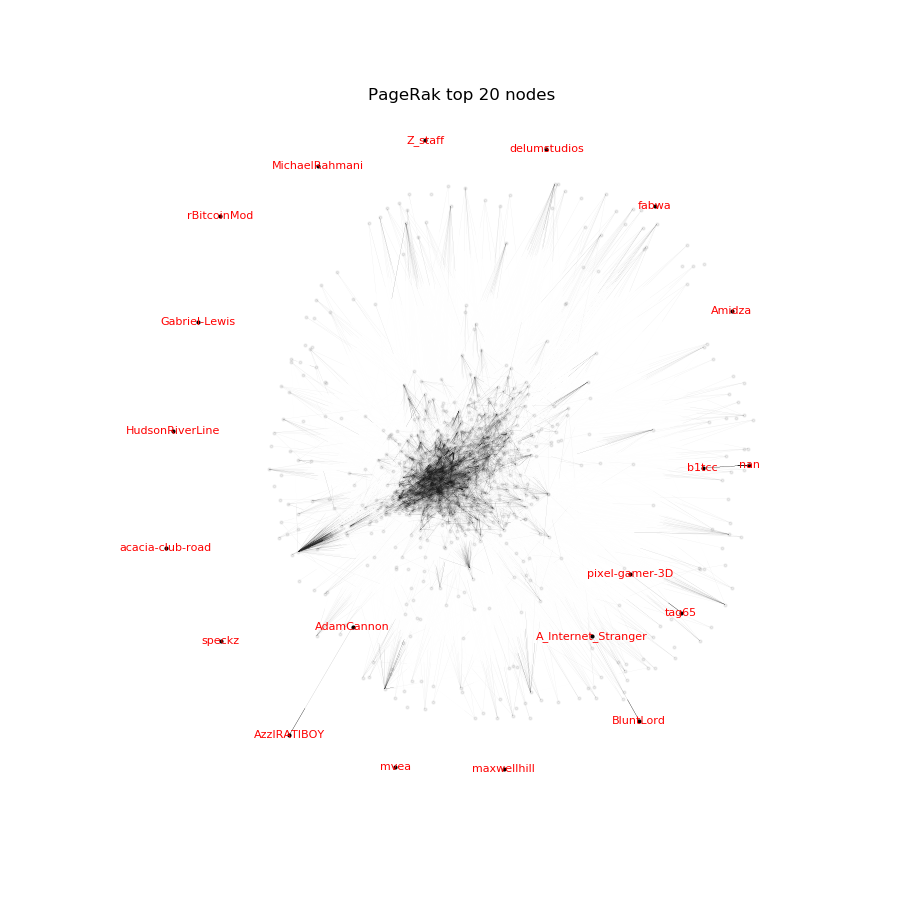

In [167]:
core1 = trim_top(g, page_rank, n=1200)
core2 = trim_top(g, page_rank, n=20)
draw_graph(core1, core2, 'PageRak top 20 nodes')

1200 20


<IPython.core.display.Javascript object>


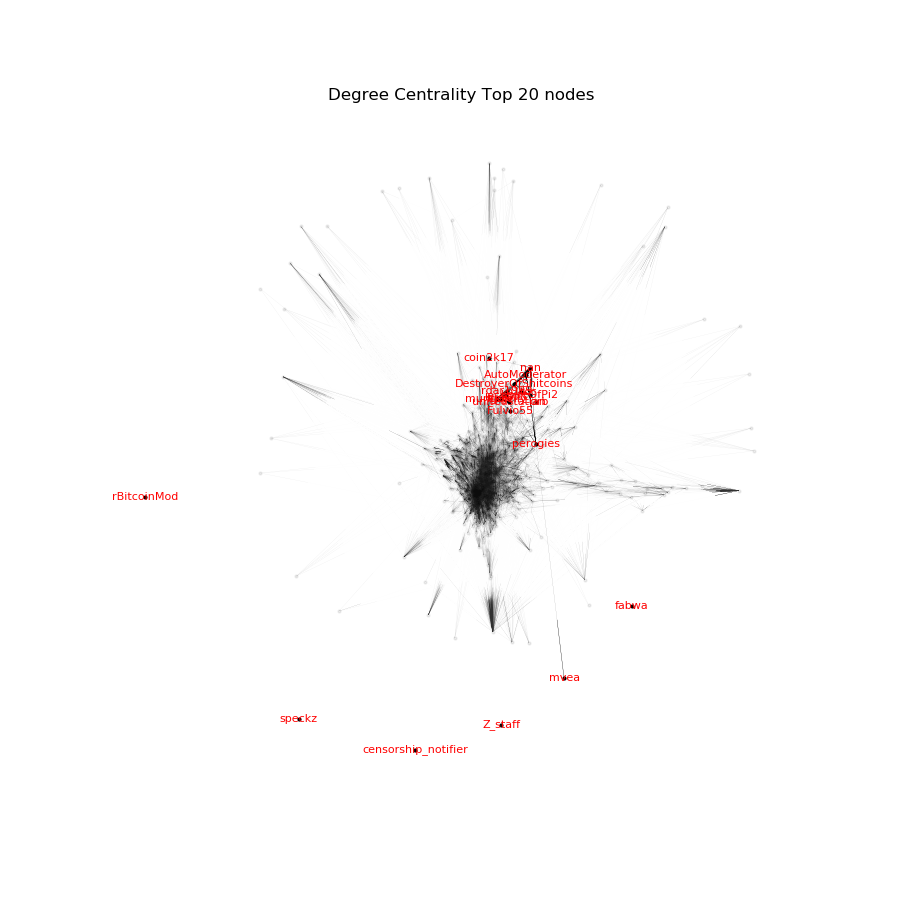

In [168]:
core1 = trim_top(g, deg_cen, n=1200)
core2 = trim_top(g, deg_cen, n=20)
draw_graph(core1, core2, 'Degree Centrality Top 20 nodes')

1200 20


<IPython.core.display.Javascript object>


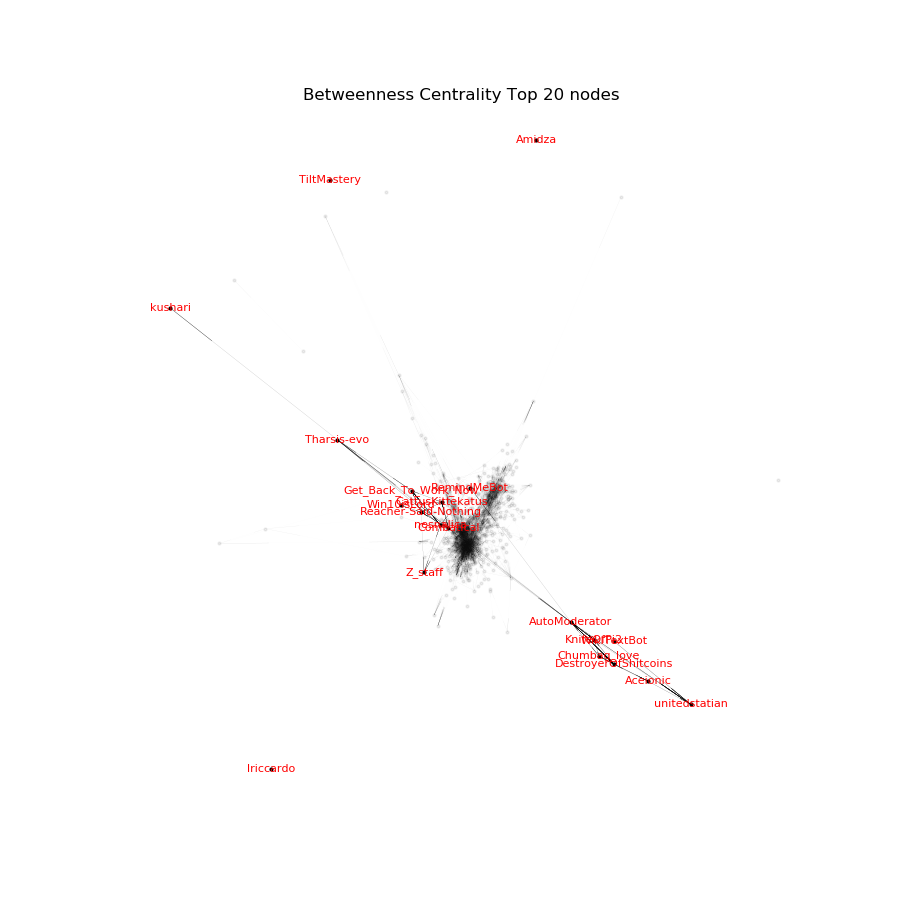

In [169]:
core1 = trim_top(g, betweenness_cen, n=1200)
core2 = trim_top(g, betweenness_cen, n=20)
draw_graph(core1, core2, 'Betweenness Centrality Top 20 nodes')

<IPython.core.display.Javascript object>


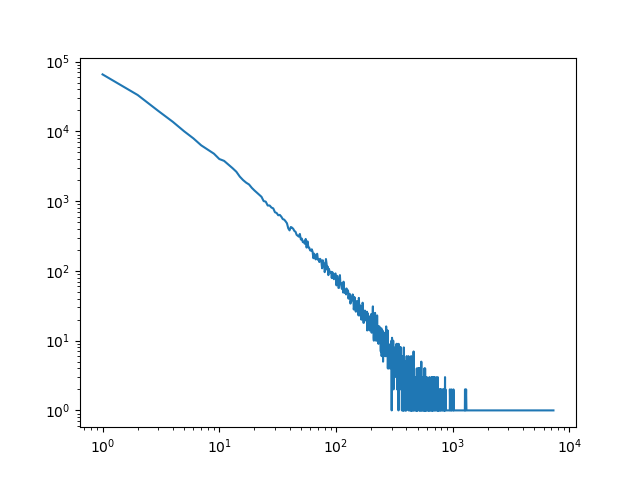

In [103]:
def plot_degree_distribution(graph):
    degs = {}
    for n in graph.nodes():
        deg = graph.degree(n)
        if deg not in degs :
            degs [deg] = 0
        degs [deg] += 1
    items = sorted(degs.items())
    fig = plt.figure ()
    ax = fig.add_subplot (111)
    ax.plot([ k for (k, v) in items], [ v for (k, v) in items ])
    ax.set_xscale('log')
    ax.set_yscale('log')
    
plot_degree_distribution(g)